#### convolution

In [2]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import gzip, pickle
import matplotlib as mpl
import pandas as pd

In [3]:
%matplotlib inline
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
data_path  = Path('./data/mnist.pkl.gz')

In [5]:
data_path.exists()

True

In [6]:
data = None
with gzip.open(data_path, 'rb') as f:
    data = pickle.load(f, encoding='latin')

In [7]:
((x_train, y_train), (x_val, y_val), _) = data

In [8]:
(x_train, y_train, x_val, y_val) = map(torch.tensor, (x_train, y_train, x_val, y_val))

In [9]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [10]:
x_imgs = x_train.view(-1, 28, 28)
xval_imgs = x_val.view(-1, 28, 28)

In [11]:
im3 = x_imgs[7]

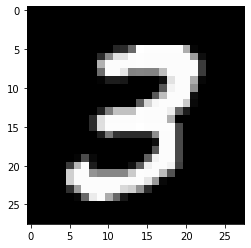

In [12]:
plt.imshow(im3)

In [13]:
top_edges = torch.tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
])

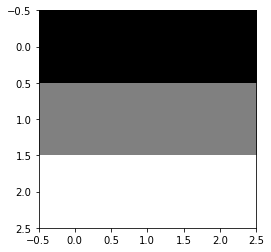

In [14]:
plt.imshow(top_edges)

In [15]:
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size': '8pt'}).background_gradient('Greens')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [16]:
(im3[3:6, 14:17] * top_edges).sum()

tensor(2.9727)

In [17]:
(im3[3:6, 14:17] * top_edges)

tensor([[-0.0000, -0.0000, -0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.9961, 0.9883, 0.9883]])

In [18]:
(im3[3:6, 14:17].to(dtype=torch.float) @ top_edges.to(dtype=torch.float)).sum()

tensor(-0.0234)

In [19]:
def apply_kernel(row, col, kernel):
    return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [20]:
apply_kernel(4, 15, top_edges)

tensor(2.9727)

In [21]:
rng = range(1, 27)
rng

range(1, 27)

In [22]:
top_edges3 = [[apply_kernel(i, j, top_edges) for j in rng] for i in rng]

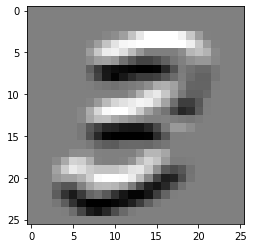

In [23]:
plt.imshow(top_edges3)

In [24]:
left_edge = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]).float()

In [25]:
lef_edges3 = [[apply_kernel(i, j, left_edge) for j in rng] for i in rng]

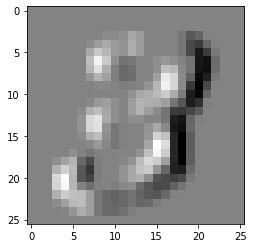

In [26]:
plt.imshow(lef_edges3)

#### convolutions in pytorch

In [27]:
import torch
import torch.nn.functional as F

In [28]:
im3.shape

torch.Size([28, 28])

In [29]:
im3[None,None,:,:].shape

torch.Size([1, 1, 28, 28])

In [30]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3, 3))[0]
inp_unf.shape

torch.Size([9, 676])

In [31]:
left_edge.shape

torch.Size([3, 3])

In [32]:
left_edge.view(-1)

tensor([-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.])

In [33]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [34]:
out_unf = w @ inp_unf
out_unf.shape

torch.Size([676])

In [35]:
out = out_unf.view(26, 26)
out.shape

torch.Size([26, 26])

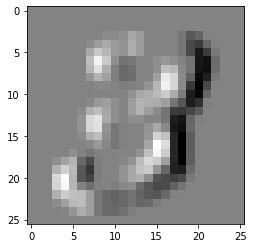

In [36]:
plt.imshow(out)

In [37]:
%timeit -n 1 [[apply_kernel(i, j, left_edge) for j in rng] for i in rng]

7.42 ms ± 685 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit -n 100 (w@F.unfold(inp, (3, 3))[0]).view(26, 26)

86 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None])

The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
97.8 µs ± 43.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [40]:
dig1_edge = torch.tensor([
    [0, -1, 1],
    [-1, 1, 0],
    [1, 0, 0]
]).float()

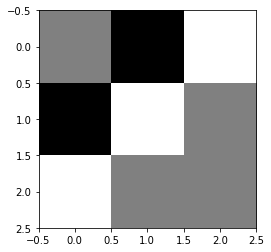

In [41]:
plt.imshow(dig1_edge)

In [42]:
dig2_edge = torch.tensor([
    [1, -1, 0],
    [0, 1, -1],
    [0, 0, 1]
]).float()

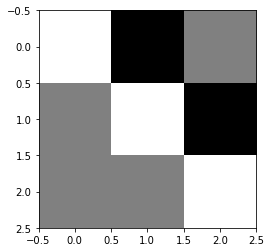

In [43]:
plt.imshow(dig2_edge)

In [44]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [45]:
edge_kernels = torch.stack([left_edge, top_edges, dig1_edge, dig2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [46]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

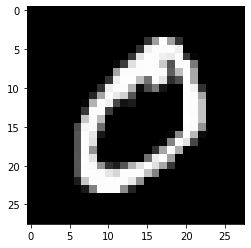

In [47]:
im0 = xb[1, 0]
plt.imshow(im0)

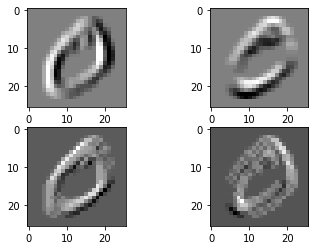

In [48]:
plt.subplot(2, 2, 1)
plt.imshow(batch_features[1, 0])

plt.subplot(2, 2, 2)
plt.imshow(batch_features[1, 1])

plt.subplot(2, 2, 3)
plt.imshow(batch_features[1, 2])

plt.subplot(2, 2, 4)
plt.imshow(batch_features[1, 3])

#### creating cnn

In [49]:
from torch import nn

In [50]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]
    
    
class DataLoader():
    def __init__(self, ds, batch_size): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]
     
    
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [51]:
m,n = x_train.shape
nh  = 50
c  = y_train.max() + 1

In [52]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1)
)

In [53]:
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [54]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [55]:
xb.shape

torch.Size([16, 1, 28, 28])

In [56]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [57]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten()
)

In [58]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [59]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [60]:
x_imgs = x_train.view(-1, 1, 28, 28)
xval_imgs = x_val.view(-1, 1, 28, 28)
train_ds, val_ds = Dataset(x_imgs, y_train), Dataset(xval_imgs, y_val)

In [61]:
from torch import optim

In [62]:
lr = 0.4
bs = 256

In [63]:
train_dl, val_dl = get_dls(train_ds, val_ds, bs)

In [64]:
opt = optim.SGD(simple_cnn.parameters(), lr)

In [65]:
loss, acc =  fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, val_dl)

0 2.2360411514282226 0.2893
1 0.2510062300205231 0.9272
2 0.1556034809887409 0.9515
3 0.17306179146766662 0.9449
4 0.14703145915716886 0.9544


#### understanding convolution arithmetic

In [68]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [69]:
conv1 = simple_cnn[0][0]
conv1

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [70]:
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [71]:
conv1.bias.shape

torch.Size([4])

#### color images

In [75]:
import torch